In [1]:
import os
import numpy as np
from Env.DC_gym import DiscreteGymDC
from Nets.DQN import DQN
from Utils.memory import Memory
import gym
import tensorflow as tf
import matplotlib.pyplot as plt

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
env = gym.make('CartPole-v0')
env.reset()
n_actions = env.action_space.n

In [15]:
"""PARAM"""
total_episodes = 1000
target_updates = 200
mem_length = 3000
gamma = 0.95
batch_size = 32

layer_size = 32
depth = 3

In [16]:
def eps_greedy(current_episode, total_episodes, start_probability=0.99, end_probability=0.01):
    epsilon = start_probability + (end_probability-start_probability)*current_episode/total_episodes
    random_number = np.random.sample(1)
    if epsilon > random_number: # exploit
        return True
    else: # explore
        return False

In [27]:
"""
# later can turn all of this into a DQN class
env = DiscreteGymDC(os.path.join(os.getcwd(), "Env\Flowsheet2_PR.fsd"), n_discretisations = 3, shuffle=True)
DQN_model = DQN(env.n_actions, env.State.state.shape).model
target_model = DQN(env.n_actions, env.State.state.shape).model
"""
tf.keras.backend.set_floatx('float64')
DQN_model = DQN(n_actions, env.observation_space.shape, layer_size=layer_size, depth = depth).model
#DQN_model = DQN(n_actions, env.observation_space.shape, schedule_lr=True, decay_steps=total_episodes/10).model
targetDQN_model = DQN(n_actions, env.observation_space.shape, layer_size=layer_size, depth = depth).model
memory = Memory(max_size=mem_length)

In [28]:
#tf.keras.utils.plot_model(DQN_model, show_shapes=True)
None

# Populate memory

In [29]:
# first populate memory with random experience
for i in range(mem_length):
    state = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        memory.add([state, action, reward, next_state, 1 - done])
        state = next_state

# Now learn

In [30]:
history = []
for i in range(total_episodes):
    state = env.reset()
    done = False
    k = 0
    total_reward = 0
    while not done:
        k += 1
        if eps_greedy(i, total_episodes*4/5) is True:
            action = np.argmax(DQN_model.predict(state[np.newaxis, :]))
        else:
            action = env.action_space.sample()
        
        # now take action
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        
        memory.add((state, action, reward, next_state, 1 - done))
        batch = memory.sample(batch_size)
        state_batch = np.array([each[0] for each in batch])
        action_batch = np.array([each[1] for each in batch])
        reward_batch = np.array([each[2] for each in batch])
        next_state_batch = np.array([each[3] for each in batch])
        done_batch = np.array([each[4] for each in batch])
        
        next_action = np.argmax(DQN_model.predict(next_state_batch), axis=1)
        y = DQN_model.predict(state_batch) # dummy values for actions that aren't taken
        y[np.arange(batch_size), action_batch] = reward_batch + done*gamma*targetDQN_model.predict(next_state_batch)[np.arange(batch_size), next_action]
        
        DQN_model.train_on_batch(x = state_batch, y=y)
  
    history.append(total_reward)         
            
    if i % target_updates == 0:
        targetDQN_model.set_weights(DQN_model.get_weights())
        print(f"Average reward of last {target_updates} episodes: {np.mean(history[-target_updates:])}")
        print(f"episode {i}/{total_episodes}")

Average reward of last 200 episodes: 9.0
episode 0/1000
Average reward of last 200 episodes: 10.06
episode 200/1000
Average reward of last 200 episodes: 12.625
episode 400/1000
Average reward of last 200 episodes: 17.45
episode 600/1000
Average reward of last 200 episodes: 19.66
episode 800/1000


In [31]:
def running_mean(x, N=100):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / N

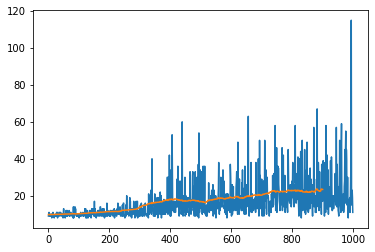

In [32]:
plt.plot(history)
plt.plot(running_mean(history))

In [33]:
test_hist = []
for _ in range(10):
    total_reward = 0
    done = False
    state = env.reset()
    while not done:
        env.render()
        action = np.argmax(DQN_model.predict(state[np.newaxis, :]))
        state, reward, done, info = env.step(action)
        total_reward += reward
    test_hist.append(total_reward)
env.close()
np.mean(test_hist)

9.1